## Creating a Combination Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import spacy
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from nltk.tokenize import RegexpTokenizer, word_tokenize
import re

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GRU, Input, Flatten, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Input, Embedding, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

### Initializations for Both Models

In [3]:
model_lr = load_model('../data/model_l.hd/')

In [4]:
model_sr = load_model('../data/model_s.hd/')

In [9]:
import numpy as np
import spacy
from sklearn.base import BaseEstimator, TransformerMixin

class WordVectorTransformer(TransformerMixin,BaseEstimator):
    def __init__(self, model="en_trf_distilbertbaseuncased_lg"):    #put bert embeddings here
        self.model = model
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        nlp = spacy.load(self.model)
        return np.concatenate([nlp(doc).vector.reshape(1,-1) for doc in X])

In [10]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [11]:
bertvect = WordVectorTransformer()

In [12]:
analyzer = SentimentIntensityAnalyzer()

### Testing Each Model Separately

Below we are creating a method of formatting the same sentence input in two different ways, to be passed into each model appropriately. model_l is the 'Language Model,' for which the input is vectorized based on bERT sentence level embeddings. model_s is the 'Sentiment Model,' for which the input's sentiments are extracted via the vader library and appropriately formatted to run a prediction.

As an addtional note, this formatting allows multiple sentences to be passed in as well, and each one will be predicted by each of the two models.

In [75]:
sentence = [["I am depressed"]]

s_input_model_l = np.array([bertvect.transform(i) for i in sentence]).reshape(-1,768,1)
s_input_model_s = pd.DataFrame([analyzer.polarity_scores(i) for i in sentence])

In [76]:
s_input_model_l.shape

(1, 768, 1)

In [77]:
model_lr.predict(s_input_model_l)

array([[0.89100426]], dtype=float32)

In [78]:
model_sr.predict(s_input_model_s)

array([[0.6287107]], dtype=float32)

### Combined Probabilities

In [19]:
def combine_predict(sentence):
    sentence = [[sentence]]
    preds = np.array([])
    
    s_input_model_l = np.array([bertvect.transform(i) for i in sentence]).reshape(-1,768,1)
    s_input_model_s = pd.DataFrame([analyzer.polarity_scores(i) for i in sentence])
    
    preds_l = model_lr.predict(s_input_model_l)
    preds_s = model_sr.predict(s_input_model_s)

    preds = 0.7*preds_l+0.3*preds_s
            
    return preds

In [14]:
combine_predict([["My story? Well, I only realised that I had symptoms of clinical depression recently. And probably that I've had it a lot longer than I thought. I was always of the belief that depression was a result of a traumatic event, a loss, stress, unhappiness at home, being bullied, those types of things. But it turns out you can just have bad brain chemistry. My brain just doesn't produce enough serotonin."]])

array([[0.90997577]], dtype=float32)

In [23]:
combine_predict("I am not depressed")

array([[0.14404175]], dtype=float32)

### Model Evaluation

In [97]:
from numpy import load

In [182]:
X_test_bvect = load('../data/X_test_bvect.npy')
X_test = pd.read_csv('../data/X_test.csv')   
y_test = pd.read_csv('../data/y_test.csv')['subreddit'].map({'CasualConversation':0, 'happy':0, 'depression':1})

In [106]:
def sentiment(row):
    analyzer = SentimentIntensityAnalyzer()
    res = analyzer.polarity_scores(row)
    return pd.Series([res['neg'], res['neu'], res['pos'], res['compound']])

In [107]:
X_test[['neg','neu','pos','comp']] = X_test['full_text'].apply(sentiment)

In [110]:
X_tests = X_test[['neg','neu','pos','comp']]
X_tests

,neg,neu,pos,comp
0,0.000,1.000,0.000,0.0000
1,0.018,0.881,0.101,0.9222
2,0.032,0.628,0.339,0.9527
3,0.080,0.710,0.210,0.6369
4,0.136,0.768,0.097,-0.8928
...,...,...,...,...
11995,0.067,0.839,0.094,0.3091
11996,0.290,0.631,0.079,-0.9948
11997,0.209,0.666,0.124,-0.9347
11998,0.337,0.663,0.000,-0.9861


In [113]:
preds_l = model_lr.predict(X_test_bvect.reshape(-1,768,1))
preds_s = model_sr.predict(X_tests)

In [176]:
preds = np.array([])
preds = (0.7*preds_l+0.3*preds_s)

In [177]:
preds

array([[0.2018948 ],
       [0.05138388],
       [0.04220482],
       ...,
       [0.94431126],
       [0.93579423],
       [0.8296521 ]], dtype=float32)

In [178]:
preds_bin = np.where(preds>0.5,1,0)

In [183]:
y_test = y_test.to_numpy()

In [180]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

In [181]:
cm = confusion_matrix(y_test,preds_bin.ravel())
cm

array([[5128,  880],
       [ 789, 5203]], dtype=int64)

Text(69.0, 0.5, 'True')

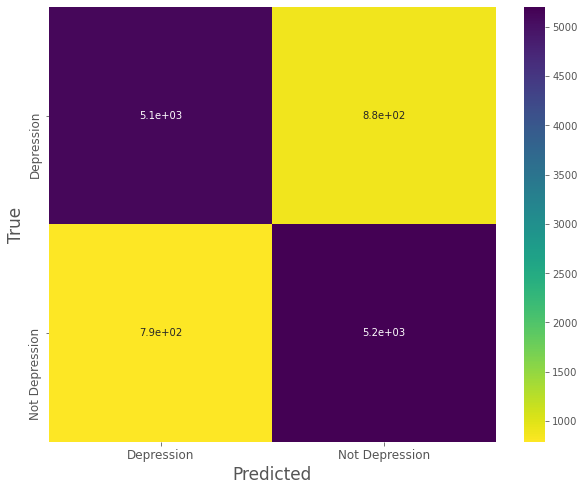

In [206]:
plt.figure(figsize=(10,8))
g = sns.heatmap(cm, annot=True, cmap='viridis_r'); #annot=True to annotate cells
g.xaxis.set_ticklabels(['Depression', 'Not Depression'],size=12)
g.yaxis.set_ticklabels(['Depression', 'Not Depression'],size=12)

g.set_xlabel("Predicted",size=17)
g.set_ylabel("True",size=17)
# X-axis is predicted labels
# y-axis is true labels

In [184]:
tn, fp, fn, tp = cm.ravel()

In [189]:
recall = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
accuracy = (tp + tn) / (tp + tn + fp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

In [194]:
clf_dict = {'recall':recall,'specificity':specificity,'precision':precision,'accuracy':accuracy,'F1':f1_score}

In [202]:
clf_df = pd.DataFrame(clf_dict,index=['Scores']).T
clf_df

,Scores
recall,0.868324
specificity,0.853529
precision,0.855335
accuracy,0.860917
F1,0.861781
